In our Lora exploration, we tried the below experiments:
- Injected Lora adapter to 3 matrices on all 24 layers: attn.c_attn, attn.c_proj, mlp.c_proj
- Set rank of Lora equals to: 1, 2, 4, 8

1. Evaluation of our Lora experiments:
- Higher perplexity and lower BLEU scores observed with full sampled data;
- For full sampled data, models with rank 1-8 show similar BLEU score.(0.41~0.42 vs 0.68 from paper)

In [5]:
import pandas as pd

# Create the data table
data = {
    'Rank': [1, 1, 2, 2, 4, 4, 8, 8],
    'Training Data (sample)': ['10%', '100%', '10%', '100%', '10%', '100%', '10%', '100%'],
    'Perplexity': [1.2001, 1.2989, 1.2011, 1.2977, 1.1972, 1.3052, 1.1990, 1.3033],
    'BLEU Score': [0.5461, 0.4215, 0.5256, 0.4176, 0.5394, 0.4172, 0.5287, 0.4239]
}

# Create DataFrame
df = pd.DataFrame(data)
df

,Rank,Training Data (sample),Perplexity,BLEU Score
0,1,10%,1.2001,0.5461
1,1,100%,1.2989,0.4215
2,2,10%,1.2011,0.5256
3,2,100%,1.2977,0.4176
4,4,10%,1.1972,0.5394
5,4,100%,1.3052,0.4172
6,8,10%,1.1990,0.5287
7,8,100%,1.3033,0.4239


# Inspection of update matrix $\delta W$:

### Analysis of update patterns reveals distinct layer specializations in e2e NLG:

1. attn.c_attn & mlp.c_proj: Higher layers (L23) show larger relative norms

- attn.c_attn: Learns what to attend to during generation

- mlp.c_proj: Learns how to express the attended content

- Both require significant adaptation in higher layers for task-specific control

2. attn.c_proj: Shows the opposite pattern - larger norms in lower layers

- L0: Heavy adaptation to reorganize structured input (name[value]) into natural language flow

- Higher layers: Smaller updates as basic reorganization is complete

This aligns with e2e's core challenge: transforming rigid structures into fluent sentences

Our hypothesis - lower layers handle structural parsing while higher layers manage generation decisions and stylistic expression.

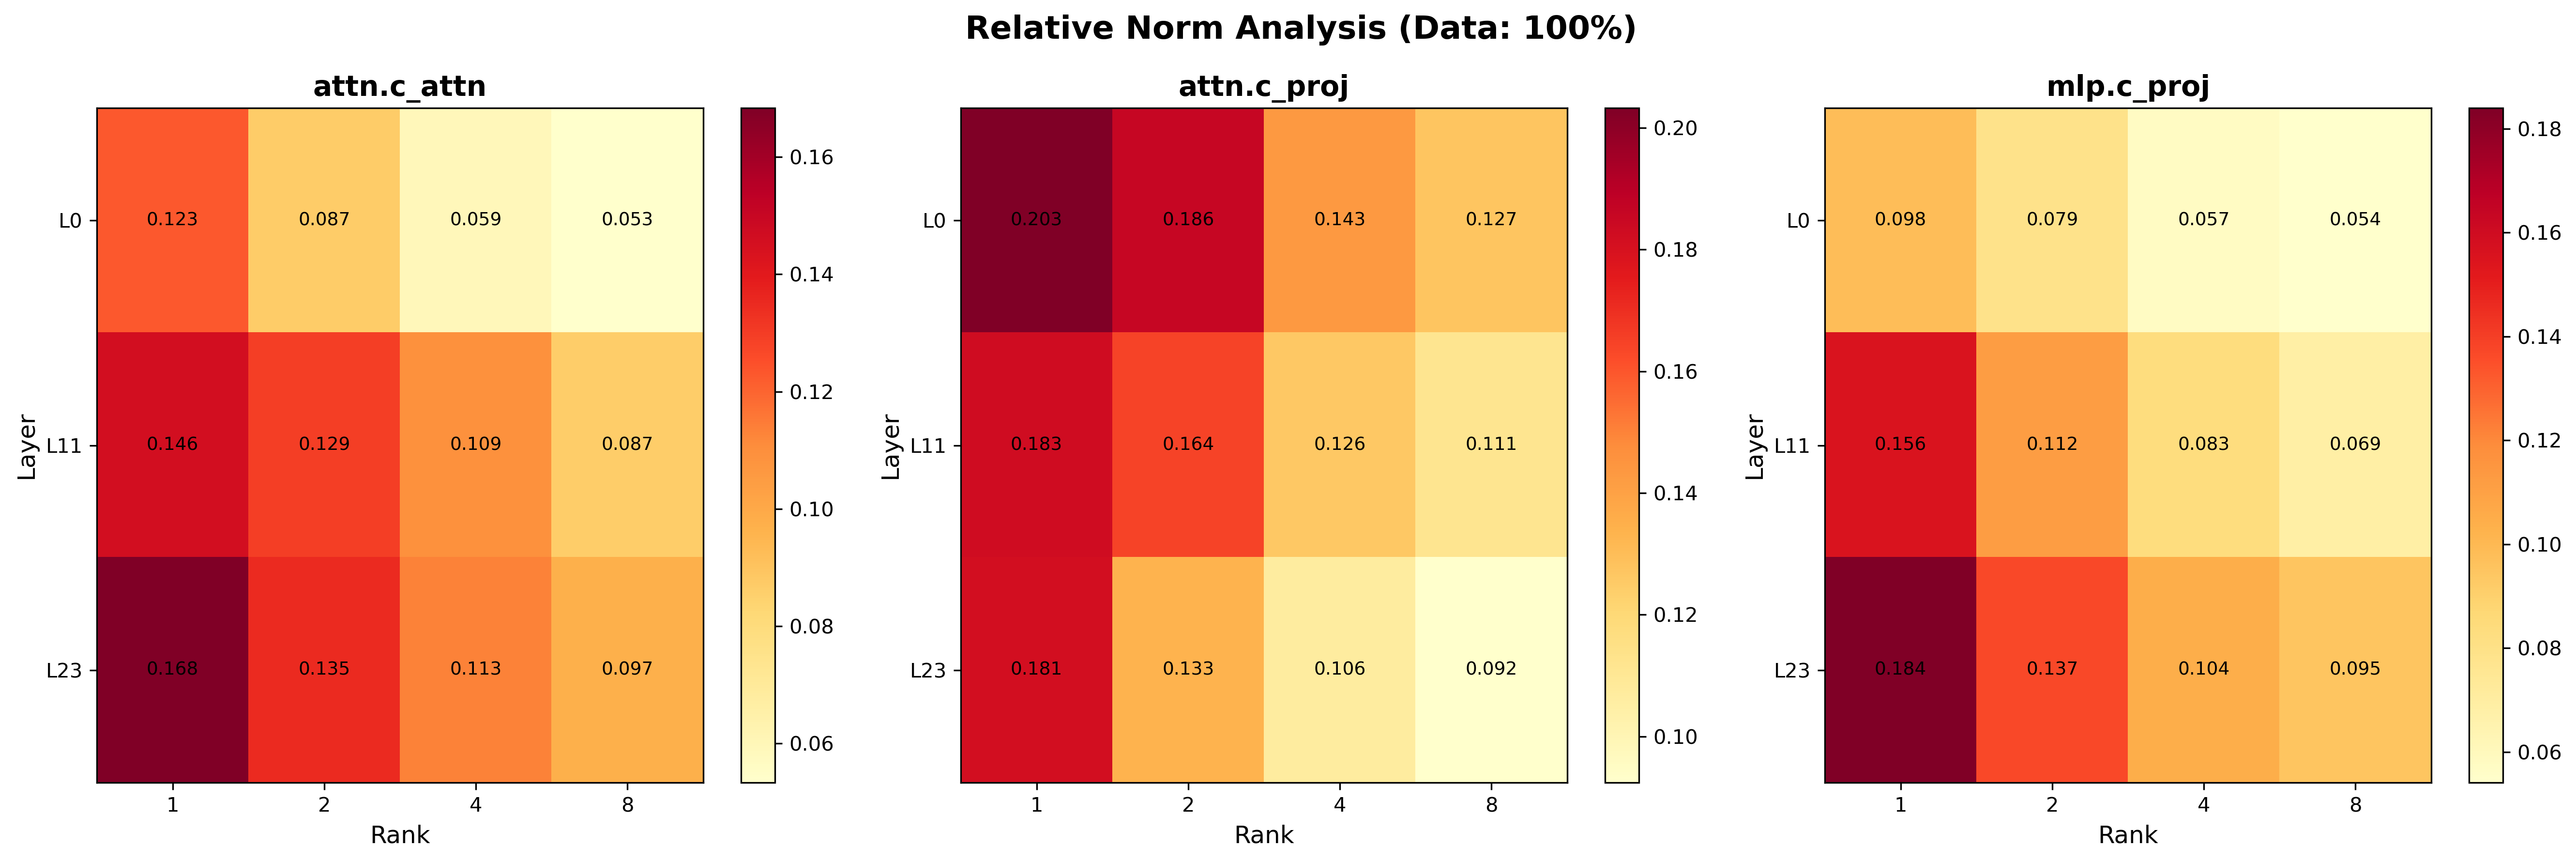

In [3]:
from IPython.display import Image, display
display(Image('lora_analysis_results/relative_norm/relative_norm_100p.png', width=1200))

The relative Frobenius norm (‖ΔW‖/‖W‖) of our LoRA adapters ranges from 5.9% to 14.3% (for r=4), aligning with 11.1% reported in the original LoRA paper for GPT-3. This confirms our updates are appropriately scaled.
Despite proper scaling, our BLEU score remains low at 0.4 for text rewriting. This suggests:
- LoRA is amplifying features present in pre-training
- But it may be amplifying the wrong features for our specific task
- The model changes significantly without achieving the desired rewriting behavior

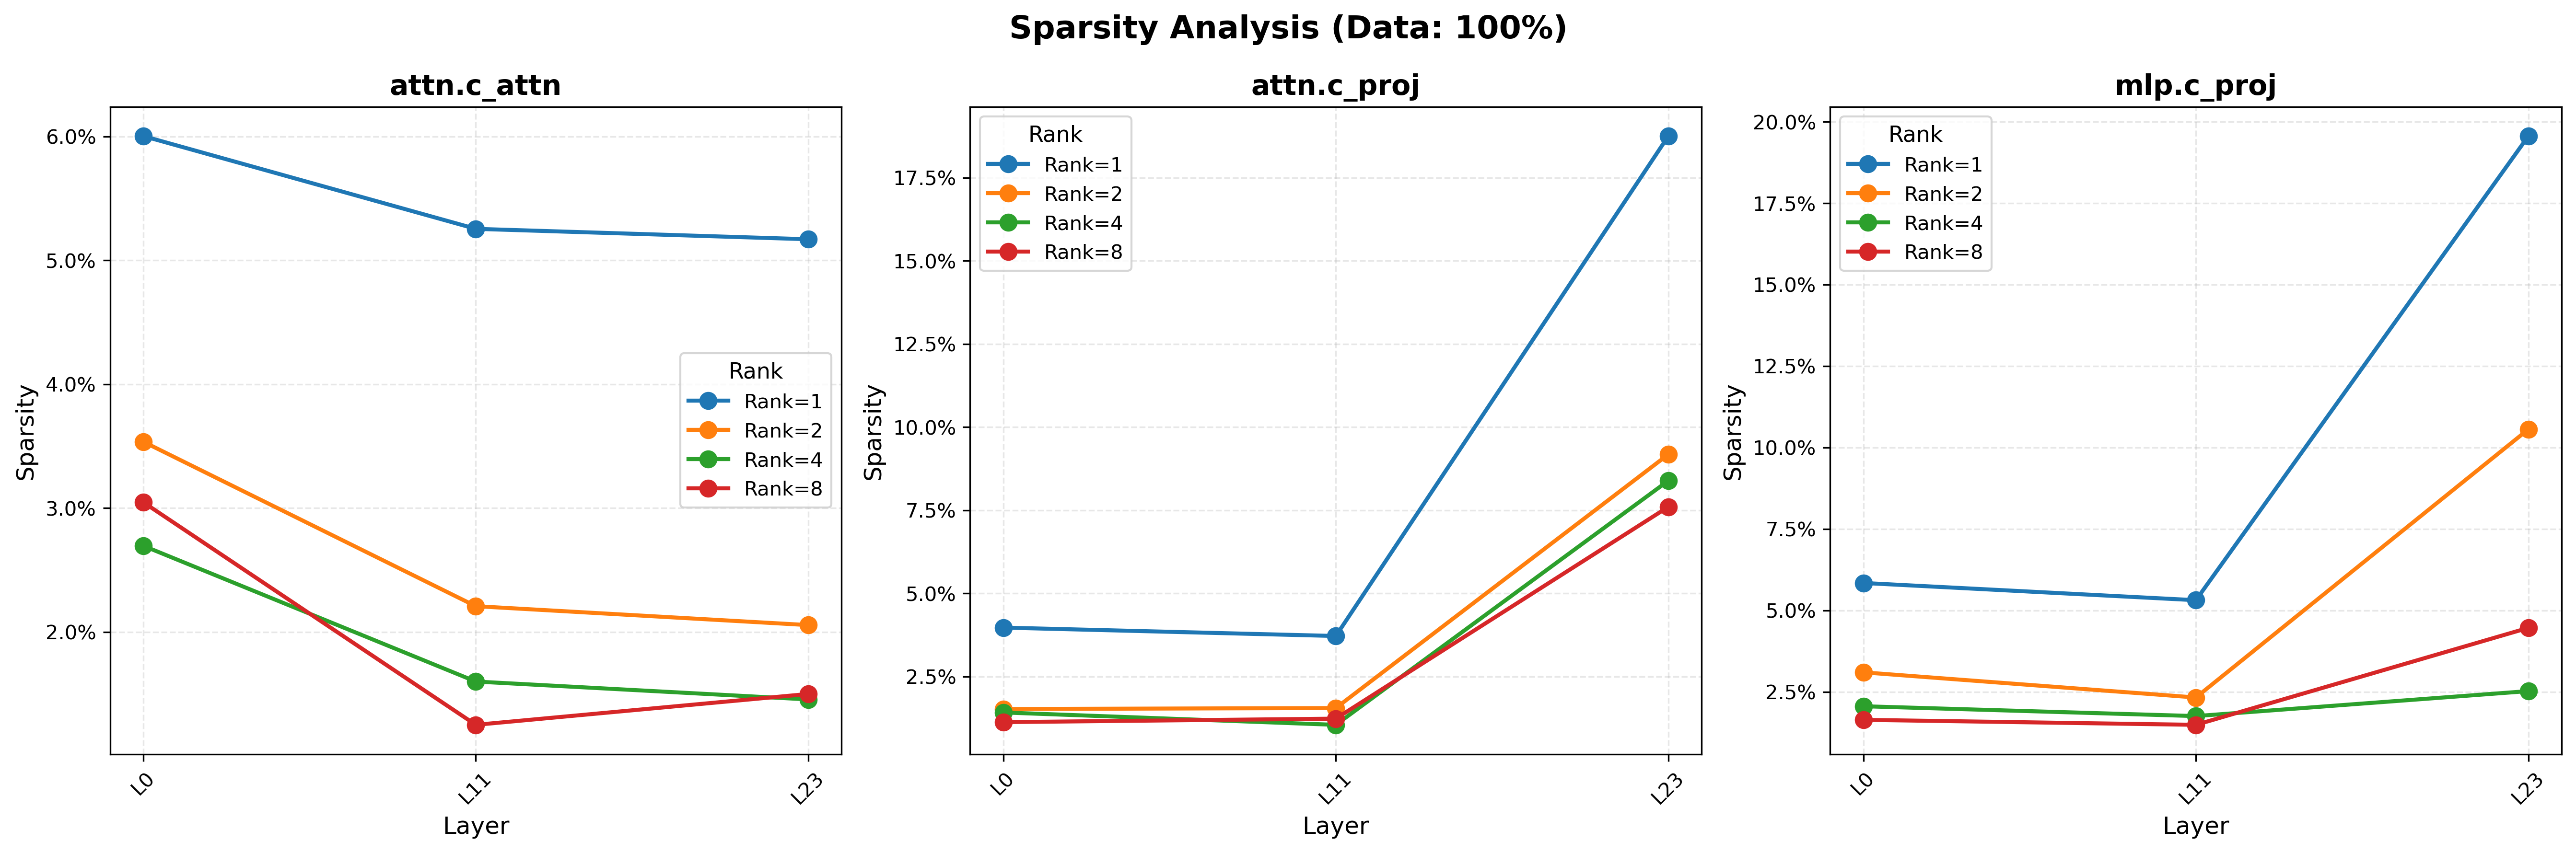

In [4]:
display(Image('lora_analysis_results/sparsity/sparsity_100p.png', width=1200))

#### For rank = 8:
Sparsity is comparable between rank 4 and 8, but the relative norm decreases (see above). More importantly, only about half of the singular values are needed to capture 95% of the matrix energy (see below) — meaning most of the essential information is already contained within four singular values rather than eight.

This suggests rank = 8 is inefficient, as half of the ranks contribute little to the overall representation, resulting in wasteful parameter usage.

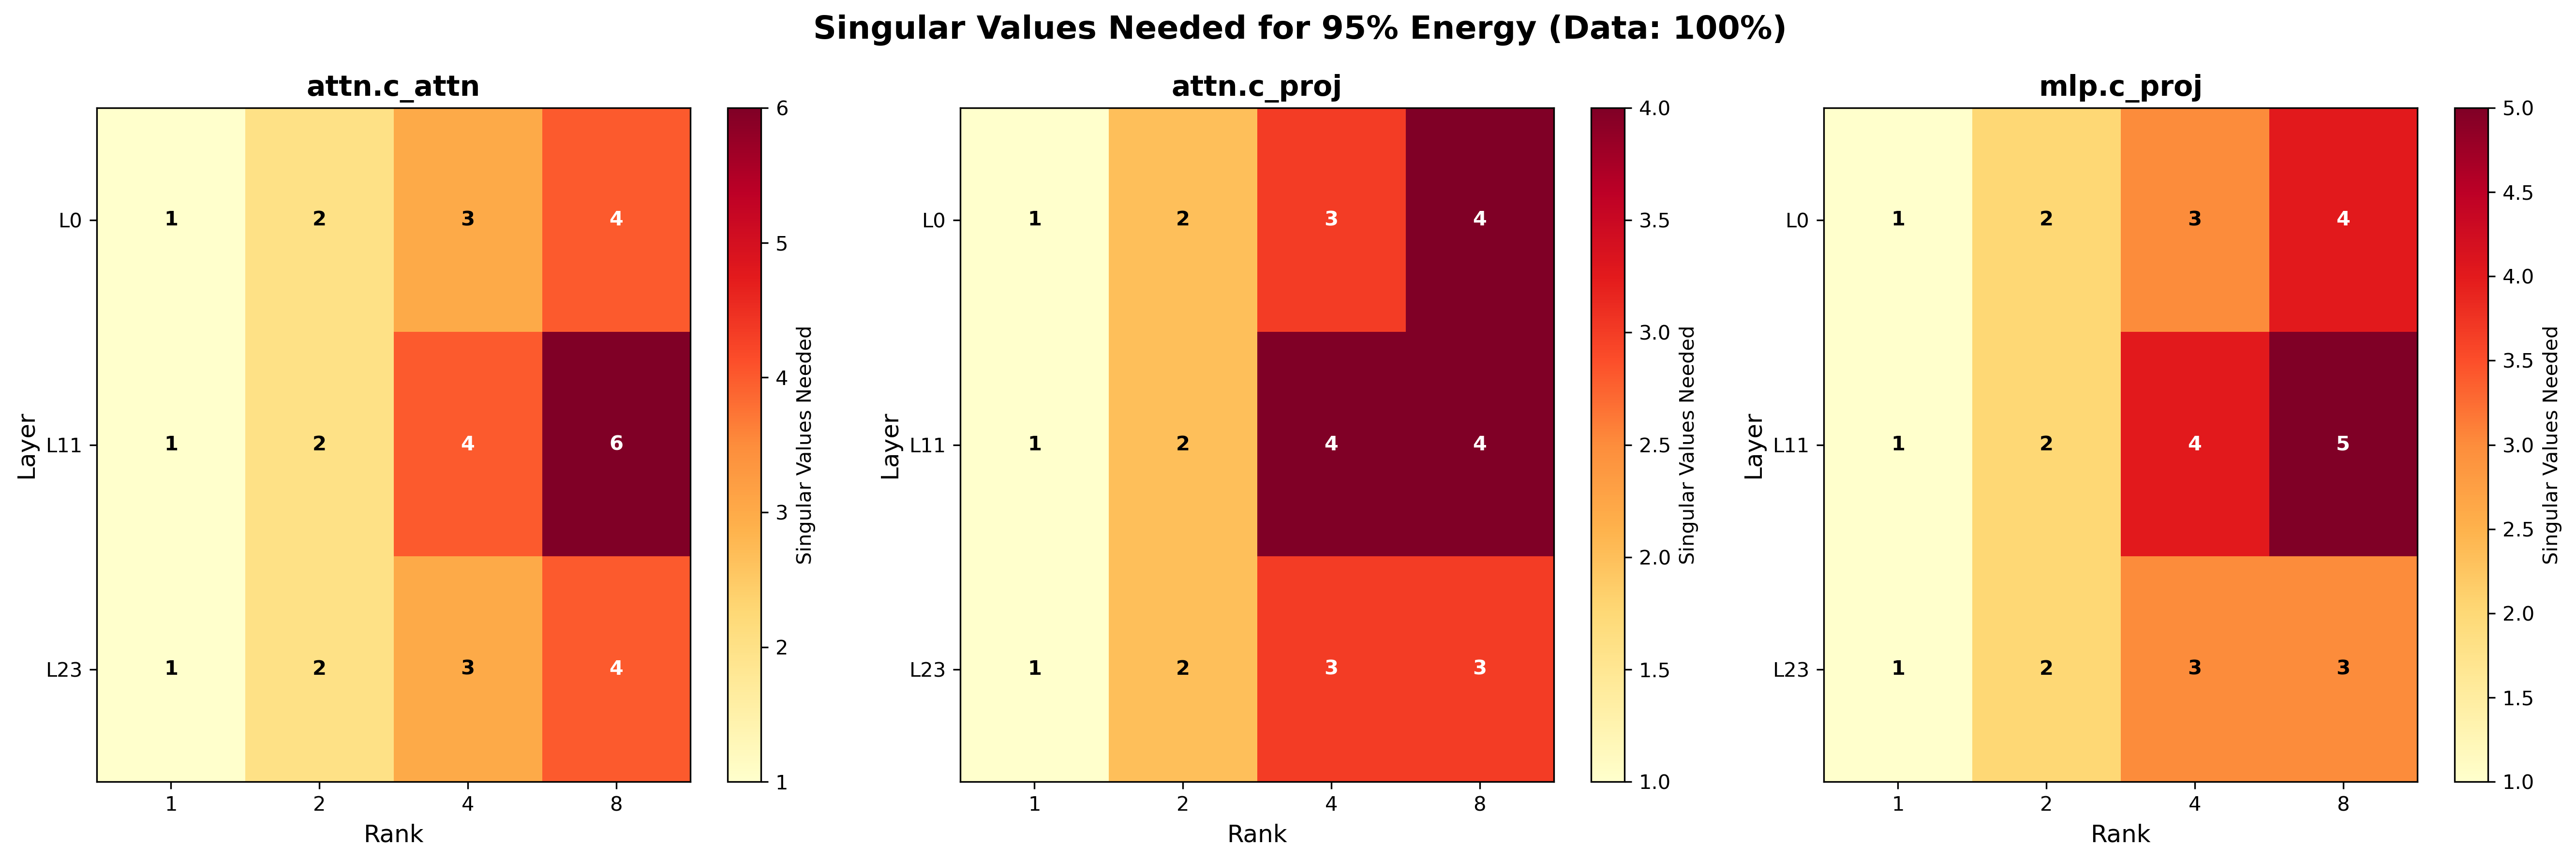

In [5]:
display(Image('lora_analysis_results/sv_for_95percent/sv_for_95percent_100p.png', width=1200))

The relative Frobenius norm (‖ΔW‖/‖W‖) of our LoRA adapters ranges from 5.9% to 14.3% (for r=4), aligning with 11.1% reported in the original LoRA paper for GPT-3. This confirms our updates are appropriately scaled.
Despite proper scaling, our BLEU score remains low at 0.4 for text rewriting. This suggests:
- LoRA is amplifying features present in pre-training
- But it may be amplifying the wrong features for our specific task
- The model changes significantly without achieving the desired rewriting behavior